<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Компания (заказчик):** Компания «Чётенькое такси».

**Задача:** Привлечение большего количества водителей такси в период пиковой нагрузки.

**Цель:** Прогноз количества заказов такси на следующий час. Построение модели для такого предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Данные:** Исторические данные о заказах такси в аэропортах. Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Алгоритм:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from lightgbm import LGBMRegressor 

In [2]:
try:
    data = pd.read_csv('ataxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()
data.head(15)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
data=data.sort_index()
print(data.index.is_monotonic)

True


In [5]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


На этапе подготовки данных создан датасет с индексами временного ряда, проверили на монотонность и рассемплировали данные по 1 часу. Данные с 1 марта 2018 по 31 августа 2018, всего 26 496 записей, достаточно для анализа.
Типы данных менять не требуется.

## Анализ

Проанализируем количество заказов такси и скользящее среднее.

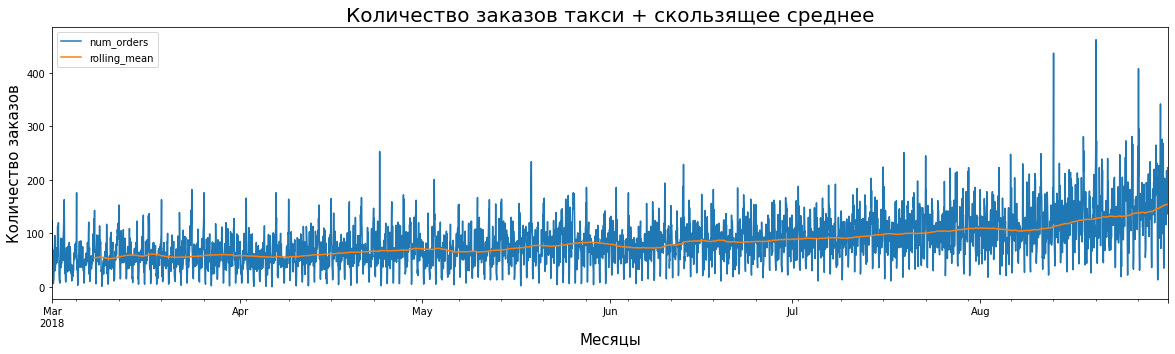

In [6]:
data['rolling_mean'] = data.rolling(24*7).mean()
figsize = (20, 5)
data.plot(figsize=figsize)
plt.title('Количество заказов такси + скользящее среднее', fontsize=20)
plt.xlabel('Месяцы', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.show()

Чтобы лучше понимать временной ряд, разберём тренды и сезонность.

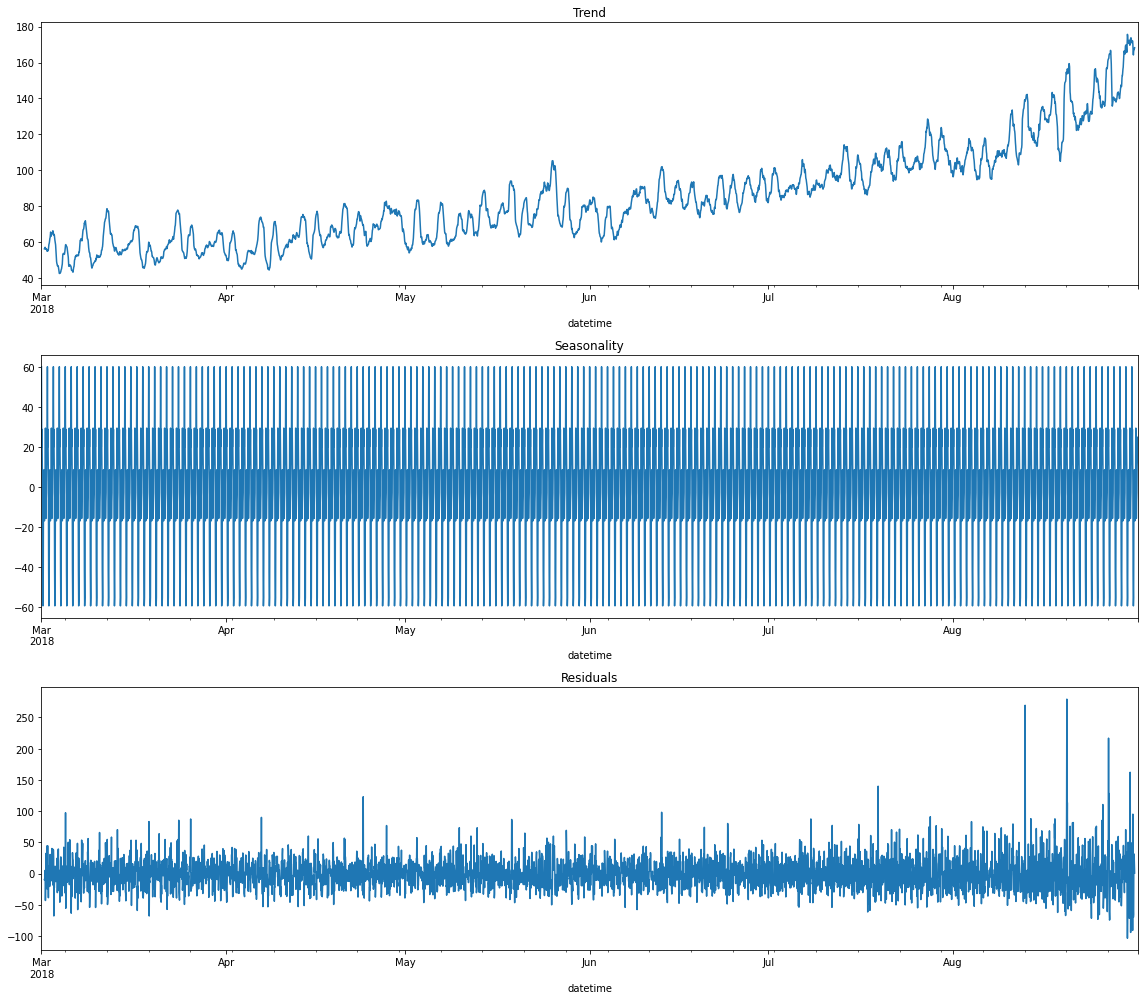

In [7]:
decomposed = seasonal_decompose(data.drop(['rolling_mean'], axis = 1))

plt.figure(figsize=(16, 14))
plt.subplot(311)

ax=plt.gca()
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Наблюдаем Тренд на увеличение количества заказов в течении года. Тренд указывает на увеличение заказов. Сезоность указывает на высокий спрос на такси в ночное время.

Рассмотим сезонность заказов на отдельном примере. Возьмем данные за август.

<AxesSubplot:title={'center':'Сезонность заказов за август'}, xlabel='datetime'>

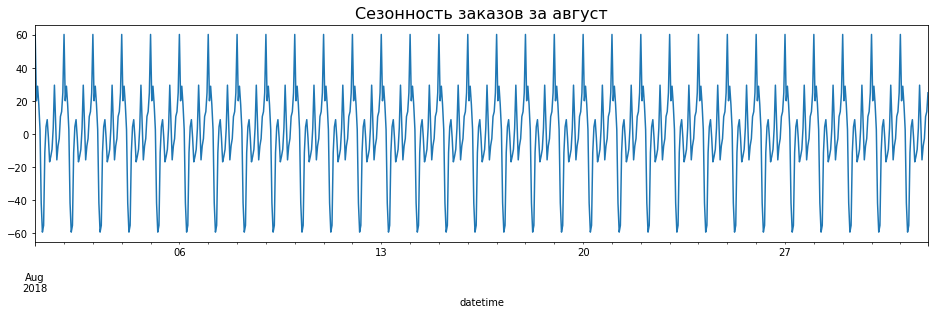

In [8]:
plt.figure(figsize=(16,4))
plt.title('Сезонность заказов за август', fontsize=16)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())

<AxesSubplot:title={'center':'Сезонность заказов за последние три дня августа'}, xlabel='datetime'>

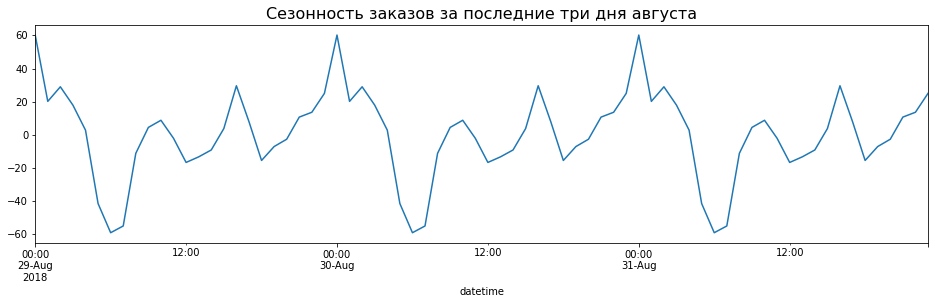

In [9]:
plt.figure(figsize=(16,4))
plt.title('Сезонность заказов за последние три дня августа', fontsize=16)
decomposed.seasonal['2018-08-29':].plot(ax=plt.gca())

Да, наблюдаем пик заказов в полночь и спад заказов до 10 утра. С 18 вечера до 24:00 активный рост.

## Обучение

Итак, подготовим необходимые признаки. day, month, dayofweak, year. Разделим выборки (10% на тестовую остальные на обучающую). И подготовим итоговые признаки для обучения моделей.

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 500, 300)
data.shape

(4416, 506)

In [11]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=1515)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Для удобства изначально напишем функцию для расчета RMSE.

**Линейная регрессия. LinearRegression.**

In [12]:
from sklearn.model_selection import TimeSeriesSplit

In [14]:
from sklearn.model_selection import cross_val_score

In [13]:
tscv = TimeSeriesSplit(n_splits=8)

In [20]:
%%time

tscv = TimeSeriesSplit(n_splits=8)
regression_model = LinearRegression()

cv_RMSE_LR = (cross_val_score(regression_model, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE Линейной регрессии:', cv_RMSE_LR)

RMSE Линейной регрессии: 27.958704080366346
CPU times: user 12.4 s, sys: 18.4 s, total: 30.8 s
Wall time: 30.8 s


**Случайный лес. RandomForestRegressor.**

In [22]:
%%time

tscv = TimeSeriesSplit(n_splits=8)
forest = RandomForestRegressor()

rf_params = {
        'n_estimators' : range(50, 100, 10),
        'max_depth' : range(5, 15, 2)}

In [23]:
%%time
rf_grid = GridSearchCV(RandomForestRegressor(), param_grid = rf_params, refit=False, scoring='neg_mean_squared_error', cv=tscv)
rf_grid.fit(features_train, target_train)

CPU times: user 1h 1min 16s, sys: 8.38 s, total: 1h 1min 25s
Wall time: 1h 1min 28s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(5, 15, 2),
                         'n_estimators': range(50, 100, 10)},
             refit=False, scoring='neg_mean_squared_error')

In [27]:
forest_params = rf_grid.best_params_
forest_model = RandomForestRegressor(random_state=12345,
                                     max_depth=forest_params['max_depth'],
                                     n_estimators = forest_params['n_estimators'])

cv_RMSE_forest_model = (cross_val_score(forest_model,
                                features_train, 
                                target_train, 
                                cv=tscv, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('RMSE RandomForestRegressor. =', cv_RMSE_forest_model)

RMSE RandomForestRegressor. = 22.89009296608822


In [49]:
forest_model = RandomForestRegressor(random_state=12345,
                                     max_depth=forest_params['max_depth'],
                                     n_estimators = forest_params['n_estimators'])
forest_model.fit(features_train, target_train)

RandomForestRegressor(max_depth=11, n_estimators=90, random_state=12345)

**Градиентный бустинг. LightGBM**

In [28]:
from lightgbm import LGBMRegressor

In [29]:
%%time

tscv = TimeSeriesSplit(n_splits=8)
lg = LGBMRegressor()
# словарь с набором параметров
lg_parametrs = {"max_depth": [1, 30, 50],
               "learning_rate" : [0.1, 0.2],
               "num_leaves": [60, 100],
               "n_estimators": range (5, 15, 5)
             }
# GridSearchCV с кросс-валидацией
lg_grid = GridSearchCV(lg, lg_parametrs, scoring=RMSE_score, cv=tscv)
lg_grid.fit(features_train, target_train)

CPU times: user 3min 18s, sys: 2.51 s, total: 3min 21s
Wall time: 3min 22s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [1, 30, 50],
                         'n_estimators': range(5, 15, 5),
                         'num_leaves': [60, 100]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [30]:
%%time

lg_params = lg_grid.best_params_
lg_score = lg_grid.score(features_train, target_train) * (-1)
print(lg_params)
print(lg_score)

{'learning_rate': 0.2, 'max_depth': 30, 'n_estimators': 10, 'num_leaves': 100}
12.804857889426712
CPU times: user 86.4 ms, sys: 391 µs, total: 86.7 ms
Wall time: 30.1 ms


In [43]:
lg_model = LGBMRegressor(max_depth= lg_params['max_depth'],
                             learning_rate = lg_params['learning_rate'],
                             num_leaves = lg_params['num_leaves'],
                             n_estimators = lg_params['n_estimators'])

cv_RMSE_forest_lg_model = (cross_val_score(lg_model,
                                features_train, 
                                target_train, 
                                cv=tscv, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('RMSE LightGBM =', cv_RMSE_forest_lg_model)

RMSE LightGBM = 24.196351816596977


In [44]:
lg_model = LGBMRegressor(max_depth= lg_params['max_depth'],
                             learning_rate = lg_params['learning_rate'],
                             num_leaves = lg_params['num_leaves'],
                             n_estimators = lg_params['n_estimators'])

lg_model.fit(features_train, target_train)

LGBMRegressor(learning_rate=0.2, max_depth=30, n_estimators=10, num_leaves=100)

При обучении трех моделей наилучший результат RMSE у модели Случайный лес. RandomForestRegressor при параметрах max_depth=11, n_estimators=90

## Тестирование

Проверим результат последней лучшей модели на тестовой выборке.

In [50]:
predictions_test = forest_model.predict(features_test)
rmse_test = mean_squared_error(target_test, predictions_test) ** 0.5
rmse_test

38.56395639931655

**Общий вывод.** 

Итак, проекте были:

- загрузужены данные
- проведен их анализ
- выполнено сравнение 3-х моделей с разными гиперпараметрами, выбрана лучшая модель по RMSE, проверена на тестовой выборке. 

На этапе подготовки данных был создан датасет с индексами временного ряда, проведено рассемплирование данные по 1 часу. Данные с 1 марта 2018 по 31 августа 2018, всего 26 496 записей. В ходе анализа было выявлено, что наблюдается Тренд на увеличение количества заказов в течении года. Сезоность указывает на высокий спрос на такси в ночное время (С 18 вечера до 24:00 активный рост заказов).

Были обучены три модели: Линейная регрессия, случайный лес и LGBMRegressor с гиперпараметрами. 

Итог - наилучшей моделью стала модель - Случайный лес. RandomForestRegressor. при параметрах max_depth=11, n_estimators=90. На тестовой выборке результат RMSE < 48 (по условию). 38,5 на тестовой выборке. 

Таким образом, модель можно рекомендовать к исполнению.